In this notebook I tried various things: different models, different ways to form input/output pairs, data augmentation etc but non proved worthwhile

**Imports**

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import csv
import math
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten, Reshape, Dropout, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from keras import backend as K
from keras.constraints import MinMaxNorm
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.metrics import RootMeanSquaredError
from keras.layers import Dropout,  TimeDistributed
from keras.regularizers import l2
from keras.callbacks import Callback

**CUDA**

In [2]:
len(tf.config.list_physical_devices('GPU'))>0

True

In [5]:
folder_path = 'data/final_run 250x250'

# List to store each DataFrame
df_list = []

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        # Read each file into a DataFrame and append to the list
        file_path = os.path.join(folder_path, filename)
        try:
            df = pd.read_csv(file_path, delimiter=',')
            if 'mcsteps' in df.columns:
                df_list.append(df)
            else:
                print(f"Column 'mcsteps' not found in file: {file_path}")
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")

# Check if we have any DataFrames to concatenate
if df_list:
    # Concatenate all DataFrames
    concatenated_df = pd.concat(df_list, ignore_index=True)

    # Sort by the 'mcsteps' column
    sorted_df = concatenated_df.sort_values(by='mcsteps')

    # Save the sorted DataFrame to a new .txt file
    output_path = os.path.join(folder_path, 'concatenated_sorted.txt')
    sorted_df.to_csv(output_path, sep=',', index=False)

    print(f"Concatenated and sorted file saved to {output_path}")
else:
    print("No valid DataFrames to concatenate.")

Concatenated and sorted file saved to data/final_run 250x250\concatenated_sorted.txt


In [7]:
# Define the input and output file paths
input_file_path = 'data/final_run 250x250/concatenated_sorted.txt'
output_file_path = 'data/final run concat 250x250.csv'

# Read the .txt file into a pandas DataFrame
df = pd.read_csv(input_file_path, delimiter=',')

# Save the DataFrame to a .csv file
df.to_csv(output_file_path, index=False)

print(f"File converted and saved as {output_file_path}")

File converted and saved as data/final run concat 250x250.csv


**Convert .txt to .csv**

In [ ]:
input_folder = "C:/Users/Giannis/Documents/uva-thesis/data/conc_txt_test"
output_folder = "C:/Users/Giannis/Documents/uva-thesis/data/test_data"

# create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# iterate through files in input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".txt"):
        try:
            # construct input and output file paths
            input_filepath = os.path.join(input_folder, filename)
            output_filepath = os.path.join(output_folder, os.path.splitext(filename)[0] + ".csv")

            # read txt file and remove leading and trailing quotation marks from each line
            with open(input_filepath, 'r') as file:
                lines = [line.strip().strip('"') for line in file.readlines()]

            # remove every other line (gap lines)
            lines = [line for index, line in enumerate(lines) if index % 2 == 0]

            # check if all lines have the same number of elements
            num_elements = len(lines[0].split(','))
            if all(len(line.split(',')) == num_elements for line in lines):
                # convert to df and save as csv
                df = pd.DataFrame([line.split(',') for line in lines])
                df.to_csv(output_filepath, index=False, header=False, quoting=csv.QUOTE_NONE, escapechar=' ')
                print(f"Converted {input_filepath} to {output_filepath}")
            else:
                print(f"Skipping {input_filepath}: Inconsistent number of elements in lines")
        except Exception as e:
            print(f"Error converting {input_filepath}: {e}")

**Concat the cytokines data to create the 'test_data_concat' folder**

In [3]:
base_cytokine_folder = "C:/Users/Giannis/Documents/uva-thesis/data/test_data"
output_folder = "C:/Users/Giannis/Documents/uva-thesis/data/test_data_concat"

def concat_files_in_folder(folder_path):
    test_data_concat = pd.DataFrame()
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            test_data_concat = pd.concat([test_data_concat, df])
    return test_data_concat

def sort_by_mcsteps(data):
    return data.sort_values(by='mcsteps')

concatenated_data = concat_files_in_folder(base_cytokine_folder)

sorted_data = sort_by_mcsteps(concatenated_data)

output_filepath = os.path.join(output_folder, "sorted_concatenated_data.csv")
sorted_data.to_csv(output_filepath, index=False)
print(f"Sorted and concatenated data saved to: {output_filepath}")

Sorted and concatenated data saved to: C:/Users/Giannis/Documents/uva-thesis/data/test_data_concat\sorted_concatenated_data.csv


**Load data for test_data_concat and drop zCOM**

In [229]:
sorted_concatenated_csv = "C:/Users/Giannis/Documents/uva-thesis/data/test_data_concat/sorted_concatenated_data.csv"
data = pd.read_csv(sorted_concatenated_csv)
data.drop(columns=['zCOM'], inplace=True)
print(data.head())

   mcsteps  xCOM  yCOM           il8  il1  il6  il10  tnf  tgf
0        0    33    22  3.750408e-07  0.0  0.0   0.0  0.0  0.0
1        0    11    32  4.793328e-09  0.0  0.0   0.0  0.0  0.0
2        0    30    35  8.997935e-09  0.0  0.0   0.0  0.0  0.0
3        0    17    40  1.781103e-08  0.0  0.0   0.0  0.0  0.0
4        0    21    23  4.789621e-09  0.0  0.0   0.0  0.0  0.0


In [230]:
data['time'] = (data['mcsteps'] / 10000).astype(int)
data = data[['time'] + [col for col in data.columns if col != 'time']]
data.drop(columns=['mcsteps'], inplace=True)
print(data)

       time  xCOM  yCOM           il8           il1           il6  \
0         0    33    22  3.750408e-07  0.000000e+00  0.000000e+00   
1         0    11    32  4.793328e-09  0.000000e+00  0.000000e+00   
2         0    30    35  8.997935e-09  0.000000e+00  0.000000e+00   
3         0    17    40  1.781103e-08  0.000000e+00  0.000000e+00   
4         0    21    23  4.789621e-09  0.000000e+00  0.000000e+00   
...     ...   ...   ...           ...           ...           ...   
86155   100    49    35 -8.886183e-11  6.343394e-10  1.206925e-08   
86156   100    36     4  1.334245e-07  1.665160e-07  1.305691e-08   
86157   100    49    44 -1.233990e-10  1.178848e-09  1.615457e-07   
86158   100    45    10  3.257988e-07  4.403049e-08  1.749928e-07   
86159   100    35    38  2.107191e-05  9.170692e-08  5.693712e-19   

               il10           tnf           tgf  
0      0.000000e+00  0.000000e+00  0.000000e+00  
1      0.000000e+00  0.000000e+00  0.000000e+00  
2      0.000000e+00  

In [92]:
import itertools

time_step_dfs = []

for time_step in range(101):
    
    # Generate all possible combinations of 'xCOM' and 'yCOM' for the current time step
    combinations = list(itertools.product(range(51), range(51)))
    possible_combinations = pd.DataFrame(combinations, columns=['xCOM', 'yCOM'])
    possible_combinations['time'] = time_step
    
    # Merge the possible combinations with the original data for the current time step to identify missing combinations
    merged_data = pd.merge(possible_combinations, data[data['time'] == time_step], on=['time', 'xCOM', 'yCOM'], how='left')
    
    # Fill missing values with 0
    merged_data.fillna(0, inplace=True)
    
    # Append the merged DataFrame to the list
    time_step_dfs.append(merged_data)

# Concatenate all DataFrames along the rows
filled_data = pd.concat(time_step_dfs, ignore_index=True)

# Drop duplicate rows
filled_data.drop_duplicates(inplace=True)

print(filled_data)

filled_data.to_csv('filled_data.csv', index=False)

        xCOM  yCOM  time  il8  il1  il6  il10  tnf  tgf
0          0     0     0  0.0  0.0  0.0   0.0  0.0  0.0
1          0     1     0  0.0  0.0  0.0   0.0  0.0  0.0
2          0     2     0  0.0  0.0  0.0   0.0  0.0  0.0
3          0     3     0  0.0  0.0  0.0   0.0  0.0  0.0
4          0     4     0  0.0  0.0  0.0   0.0  0.0  0.0
...      ...   ...   ...  ...  ...  ...   ...  ...  ...
263861    50    46   100  0.0  0.0  0.0   0.0  0.0  0.0
263862    50    47   100  0.0  0.0  0.0   0.0  0.0  0.0
263863    50    48   100  0.0  0.0  0.0   0.0  0.0  0.0
263864    50    49   100  0.0  0.0  0.0   0.0  0.0  0.0
263865    50    50   100  0.0  0.0  0.0   0.0  0.0  0.0

[262701 rows x 9 columns]


In [20]:
cytokine_columns = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

smallest_values = df[cytokine_columns].min()
largest_values = df[cytokine_columns].max()

print("Smallest values for each cytokine:")
print(smallest_values)

print("\nLargest values for each cytokine:")
print(largest_values)

Smallest values for each cytokine:
il8     0.0
il1     0.0
il6     0.0
il10    0.0
tnf     0.0
tgf     0.0
dtype: float64

Largest values for each cytokine:
il8     2.745434e-05
il1     8.067287e-06
il6     8.228592e-07
il10    1.480818e-07
tnf     1.316345e-05
tgf     1.271714e-05
dtype: float64


In [232]:
def replace_negative_with_zero(data):
    num_negative_values = (data < 0).sum().sum()
    data[data < 0] = 0
    
    return num_negative_values

cytokine_columns = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

for col in cytokine_columns:
    num_negatives = replace_negative_with_zero(data[col])
    print(f"Number of negative values replaced with 0 in '{col}': {num_negatives}")

Number of negative values replaced with 0 in 'il8': 7147
Number of negative values replaced with 0 in 'il1': 0
Number of negative values replaced with 0 in 'il6': 0
Number of negative values replaced with 0 in 'il10': 0
Number of negative values replaced with 0 in 'tnf': 0
Number of negative values replaced with 0 in 'tgf': 0


C:\Users\Giannis\AppData\Local\Temp\ipykernel_14836\1814894933.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data < 0] = 0
C:\Users\Giannis\AppData\Local\Temp\ipykernel_14836\1814894933.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data < 0] = 0
C:\Users\Giannis\AppData\Local\Temp\ipykernel_14836\1814894933.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data < 0] = 0
C:\Users\Giannis\AppData\Local\Temp\i

In [4]:
# Load the data from CSV file
df = pd.read_csv("filled_data.csv")
# Convert DataFrame to array
data_arrays = [df[df['time'] == i].drop(columns=['time']).values for i in range(101)]

# Define the window size
window_size = 2

# Prepare input sequences and output values
X = []  # Input sequences
Y = []  # Output values

# Loop through the data arrays to create X and Y
for i in range(len(data_arrays) - window_size):
    # Extract input sequence (t=i to t=i+1)
    input_seq = [data_arrays[j] for j in range(i, i + window_size)]
    
    # Extract output value (t=i+2)
    output_val = data_arrays[i + window_size]
    
    # Append input sequence to X and output value to Y
    X.append(input_seq)
    Y.append(output_val)

# Convert lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Check the shapes of X and Y
print("Shape of X:", X.shape)  # (num_samples, 2, 2601, 8)
print("Shape of Y:", Y.shape)  # (num_samples, 2601, 8)

Shape of X: (99, 2, 2601, 8)
Shape of Y: (99, 2601, 8)


In [5]:
print(Y[0][:10])

[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  1.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  2.0000000e+00 -1.6079858e-22  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  3.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  4.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  5.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  6.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  7.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]


**Create arrays**

In [234]:
# define cytokines
cytokines = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

# get unique time values
unique_time = data['time'].unique()

arrays = {}

# iterate over unique time values
for time in unique_time:
    # filter data for current value of time
    data_time = data[data['time'] == time]
    
    # initialize 50x50x6 array for current value of time
    array = np.zeros((50, 50, len(cytokines)))
    
    # get X and Y coordinates
    x = data_time['xCOM'].astype(int)
    y = data_time['yCOM'].astype(int)
    
    # get cytokine concentrations
    concentrations = data_time[['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']].values
    
    # assign cytokine concentrations to corresponding position in array
    array[x, y, :] = concentrations
    
    # store array for current value of time
    arrays[time] = array

**Print arrays**

In [235]:
print("Number of arrays:", len(arrays))
array = arrays[91]
print("Shape of the array:", array.shape)
print("Value at position (39,25):", array[39,25])

Number of arrays: 101
Shape of the array: (50, 50, 6)
Value at position (39,25): [1.7285698e-05 7.6371320e-11 2.9109778e-14 5.1850766e-18 9.9240220e-17
 1.7688583e-11]


**read 10 sequences to predict the 11th**

In [236]:
sequence_length = 10
input_sequences = []
output_values = []

# convert dictionary values to a list of arrays
arrays_list = [arrays[key] for key in sorted(arrays.keys())]

# convert 'arrays' list to numpy array
arrays_np = np.array(arrays_list)

for i in range(len(arrays_np) - sequence_length):
    input_seq = arrays_np[i:i+sequence_length]  # input sequence of arrays
    output_val = arrays_np[i+sequence_length]   # array at next time step
    
    input_sequences.append(input_seq)
    output_values.append(output_val)

# convert lists to numpy arrays
input_sequences = np.array(input_sequences)
output_values = np.array(output_values)

In [237]:
print(input_sequences.shape)
print(output_values.shape)

(91, 10, 50, 50, 6)
(91, 50, 50, 6)


**Models**

Shape of X: (99, 2, 2601, 8)
Shape of Y: (99, 2601, 8)

In [19]:
def replace_negative_with_zero(df):
    num_negative_values = (df < 0).sum().sum()
    df[df < 0] = 0
    
    return num_negative_values

cytokine_columns = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

for col in cytokine_columns:
    num_negatives = replace_negative_with_zero(df[col])
    print(f"Number of negative values replaced with 0 in '{col}': {num_negatives}")

Number of negative values replaced with 0 in 'il8': 6795
Number of negative values replaced with 0 in 'il1': 0
Number of negative values replaced with 0 in 'il6': 0
Number of negative values replaced with 0 in 'il10': 0
Number of negative values replaced with 0 in 'tnf': 0
Number of negative values replaced with 0 in 'tgf': 0


C:\Users\Giannis\AppData\Local\Temp\ipykernel_18884\4102754413.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df < 0] = 0
C:\Users\Giannis\AppData\Local\Temp\ipykernel_18884\4102754413.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df < 0] = 0
C:\Users\Giannis\AppData\Local\Temp\ipykernel_18884\4102754413.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df < 0] = 0
C:\Users\Giannis\AppData\Local\Temp\ipykernel_188

In [18]:
df = pd.read_csv('filled_data.csv')

features = df.iloc[:, :9].values
targets = df.iloc[:, 3:].values

# Set the sequence length
seq_length = 20

# Initialize lists to store sequences
X_sequences = []
y_sequences = []

# Create sequences of length seq_length
for i in range(len(features) - seq_length - 1):
    X_sequences.append(features[i:i+seq_length])
    y_sequences.append(targets[i+seq_length])

# Convert lists to numpy arrays
X = np.array(X_sequences)
y = np.array(y_sequences)

split_index = int(len(X) * 0.8) 

# Split the data into training and test sets
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Check the shapes of the train and test data
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (210144, 20, 9)
Shape of y_train: (210144, 6)
Shape of X_test: (52536, 20, 9)
Shape of y_test: (52536, 6)


In [22]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true, axis=0)))
    return 1 - SS_res / (SS_tot + K.epsilon())


def lr_schedule(epoch, lr):
    if epoch < 5:
        return 1e-2
    if epoch < 15:
        return 1e-2
    else:
        return 1e-2

def average_relative_rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_pred - y_true) / K.clip(K.abs(y_true), K.epsilon(), None))))

def average_relative_error(y_true, y_pred):
    return K.mean(K.abs((y_pred - y_true) / K.clip(K.abs(y_true), K.epsilon(), None)))

def accuracy(y_true, y_pred):
    abs_diff = K.abs(y_true - y_pred)
    threshold = 0.1 * y_true
    accurate_predictions = K.less_equal(abs_diff, threshold)
    accuracy = K.mean(accurate_predictions)
    return accuracy

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(lr_schedule)
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=128))
#model.add(Dense(units=100, activation='relu',))
#model.add(Dropout(0.2))
#model.add(Dense(units=100, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(units=y_train.shape[1], activation='sigmoid'))

# Compile the model
initial_lr=1e-2
model.compile(optimizer=Adam(learning_rate=initial_lr), loss='mse', metrics=[r_squared, 'mape', accuracy, average_relative_rmse, average_relative_error, 'msle'])

print(model.summary())

history = model.fit(X_train, y_train, epochs=30, batch_size=100, validation_split=0.1, callbacks=[early_stopping])

loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 20, 128)           70656     
                                                                 
 lstm_16 (LSTM)              (None, 128)               131584    
                                                                 
 dense_18 (Dense)            (None, 6)                 774       
                                                                 
Total params: 203,014
Trainable params: 203,014
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
1892/1892 [==============================] - 42s 21ms/step - loss: 1.4152e-04 - r_squared: -835208.2500 - mape: 538005.7500 - accuracy: 0.0000e+00 - average_relative_rmse: 5670.9204 - average_relative_error: 5378.6099 - msle: 9.4727e-05 - val_loss: 2.7196e-08 - val_r_squared: -155.9333 - val_ma

In [348]:
y_pred= model.predict(X_test)
print(y_pred.shape)
print(y_test.shape)

1642/1642 [==============================] - 4s 3ms/step
(52536, 6)
(52536, 6)


In [23]:
y_pred2=model.predict(X_test)
print(y_test.shape)
print(y_pred2.shape)
y_pred2_shape = y_pred2.shape
y_test_shape=y_test.shape

y_pred2_flattened = np.reshape(y_pred2, (-1, y_pred2_shape[-1]))
y_test_flattened = np.reshape(y_test, (-1, y_test_shape[-1]))

# Convert to DataFrame
df = pd.DataFrame(y_pred2_flattened, columns=[f'feature_{i+1}' for i in range(y_pred2_shape[-1])])

# Save to CSV
df.to_csv('flattened_y_pred2.csv', index=False)

1642/1642 [==============================] - 13s 7ms/step
(52536, 6)
(52536, 6)


In [24]:
print(y_test_flattened.shape)
print(y_pred2_flattened.shape)

(52536, 6)
(52536, 6)


In [ ]:

num_features = y_test_flattened.shape[1]
for i in range(num_features):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_flattened[:, i], y_pred2_flattened[:, i], color='blue', alpha=0.5, label='Predicted')
    plt.scatter(y_test_flattened[:, i], y_test_flattened[:, i], color='red', alpha=0.5, label='Actual')
    plt.title(f'Feature {i+1}')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.legend()
    plt.show()

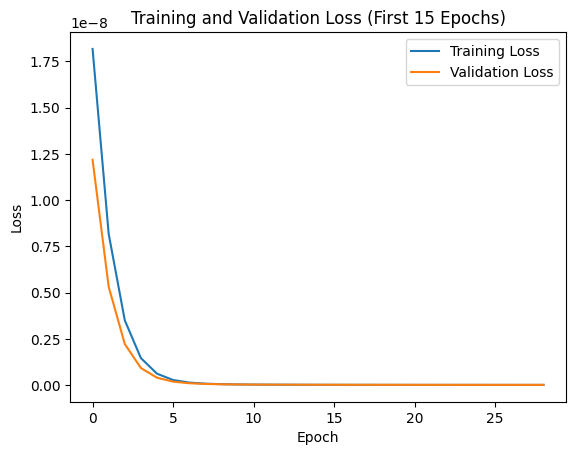

In [26]:
train_loss = history.history['loss'][1:30]
val_loss = history.history['val_loss'][1:30]
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (First 15 Epochs)')
plt.legend()
plt.show()


In [ ]:
#(91, 10, 50, 50, 6)
#(91, 50, 50, 6)

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return 1 - SS_res/(SS_tot + K.epsilon())

def lr_schedule(epoch, lr):
    if epoch < 500:
        return 1e-2
    if epoch < 1000:
        return 1e-3
    else:
        return 1e-4

def average_relative_rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_pred - y_true) / K.clip(K.abs(y_true), K.epsilon(), None))))

def average_relative_error(y_true, y_pred):
    return K.mean(K.abs((y_pred - y_true) / K.clip(K.abs(y_true), K.epsilon(), None)))

def accuracy(y_true, y_pred):
    abs_diff = K.abs(y_true - y_pred)
    threshold = 0.1 * y_true
    accurate_predictions = K.less_equal(abs_diff, threshold)
    accuracy = K.mean(accurate_predictions)
    return accuracy

#def lr_range_test(epoch, lr):
    # Start with a very small learning rate and increase exponentially
    return 10 ** (epoch / 20)  # Adjust the exponent as needed

#def explained_variance(y_true, y_pred):
    return 1 - K.var(y_true - y_pred) / K.var(y_true)

lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=200, verbose=1, restore_best_weights=True)

initial_lr = 1e-2
sequence_length = 10
input_sequences_reshaped = input_sequences.reshape(input_sequences.shape[0], input_sequences.shape[1], -1)

model = Sequential()
model.add(LSTM(units=91, input_shape=(sequence_length, 50 * 50 * 6)))
model.add(Dense(units=100, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(units=100, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(units=50 * 50 * 6, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Reshape((50, 50, 6)))
model.compile(optimizer=Adam(learning_rate=initial_lr), loss='mape', metrics=[r_squared, 'mse', accuracy, average_relative_rmse, average_relative_error, 'msle'])
print(model.summary())

history = model.fit(input_sequences_reshaped, output_values, epochs=1000, batch_size=100, validation_split=0.2, callbacks=[early_stopping, lr_scheduler])
print("Training Loss:", history.history['loss'])

loss = model.evaluate(input_sequences_reshaped, output_values)
print("Test Loss:", loss)

In [ ]:
def lr_schedule(epoch, lr):
    if epoch < 100:
        return 1e-2
    if epoch < 500:
        return 1e-3
    else:
        return 1e-4

train_size = int(0.7 * len(input_sequences))
val_size = int(0.1 * len(input_sequences))

X_train, y_train = input_sequences[:train_size], output_values[:train_size]
X_val, y_val = input_sequences[train_size:train_size+val_size], output_values[train_size:train_size+val_size]
X_test, y_test = input_sequences[train_size+val_size:], output_values[train_size+val_size:]

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = models.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class PositionalEncoding(layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-2]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions

def build_transformer_model(input_shape, num_heads, ff_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.TimeDistributed(layers.Conv2D(8, (3, 3), padding='same', activation='relu'))(inputs)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    x = layers.TimeDistributed(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    
    x = layers.Reshape((input_shape[0], -1))(x)
    
    embed_dim = x.shape[-1]
    x = PositionalEncoding(input_shape[0], embed_dim)(x)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(50 * 50 * 6)(x)
    outputs = layers.Reshape((50, 50, 6))(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (sequence_length, 50, 50, 6)
num_heads = 2  
ff_dim = 16    
model = build_transformer_model(input_shape, num_heads, ff_dim)

model.compile(optimizer='adam', loss='mse', metrics=[r_squared, 'mape', average_relative_rmse, 'msle', 'mae'])

batch_size = 32
lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=150, verbose=1, restore_best_weights=True)

initial_lr = 1e-2

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=batch_size, callbacks=[lr_scheduler, early_stopping])


test_metrics = model.evaluate(X_test, y_test)
print(f'Test Metrics: {test_metrics}')

model.summary()

In [ ]:
second_run = "C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/test_data_concat/2nd run concat.csv"
data_v = pd.read_csv(second_run)
data_v.drop(columns=['zCOM'], inplace=True)
print(data_v.head())
data_v['time'] = (data_v['mcsteps'] / 10000).astype(int)
data_v = data_v[['time'] + [col for col in data_v.columns if col != 'time']]
data_v.drop(columns=['mcsteps'], inplace=True)
print(data_v)
cytokine_columns_v = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']
smallest_values_v = data_v[cytokine_columns_v].min()
largest_values_v = data_v[cytokine_columns_v].max()

print("Smallest values for each cytokine:")
print(smallest_values_v)
print("\nLargest values for each cytokine:")
print(largest_values_v)
def replace_negative_with_zero(data_v):
    num_negative_values_v = (data_v < 0).sum().sum()
    data_v[data_v < 0] = 0

    return num_negative_values_v

cytokine_columns_v = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

for col in cytokine_columns_v:
    num_negatives_v = replace_negative_with_zero(data_v[col])
    print(f"Number of negative values replaced with 0 in '{col}': {num_negatives_v}")

# define cytokines
cytokines_v = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

# get unique time values
unique_time_v = data_v['time'].unique()

arrays_v = {}

# iterate over unique time values
for time in unique_time_v:
    # filter data for current value of time
    data_time_v = data_v[data_v['time'] == time]
    
    # initialize 50x50x6 array for current value of time
    array_v = np.zeros((50, 50, len(cytokines)))
    
    # get X and Y coordinates
    x = data_time_v['xCOM'].astype(int)
    y = data_time_v['yCOM'].astype(int)
    
    # get cytokine concentrations
    concentrations_v = data_time_v[['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']].values
    
    # assign cytokine concentrations to corresponding position in array
    array_v[x, y, :] = concentrations_v
    
    # store array for current value of time
    arrays_v[time] = array_v

In [ ]:
print("Number of arrays:", len(arrays_v))
array_v = arrays_v[0]
print("Shape of the array:", array_v.shape)
print("Value at position (0,13):", array_v[13,21])

In [ ]:
sequence_length = 10
input_sequences_v = []
output_values_v = []

# convert dictionary values to a list of arrays
arrays_list_v = [arrays_v[key] for key in sorted(arrays_v.keys())]

# convert 'arrays' list to numpy array
arrays_np_v = np.array(arrays_list_v)

for i in range(len(arrays_np_v) - sequence_length):
    input_seq_v = arrays_np_v[i:i+sequence_length]  # input sequence of arrays
    output_val_v = arrays_np_v[i+sequence_length]   # array at next time step
    
    input_sequences_v.append(input_seq_v)
    output_values_v.append(output_val_v)

# convert lists to numpy arrays
input_sequences_v = np.array(input_sequences_v)
output_values_v = np.array(output_values_v)

print(input_sequences_v.shape)
print(output_values_v.shape)

In [ ]:
third_run = "C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/test_data_concat/3rd run concat.csv"
data_t = pd.read_csv(third_run)
data_t.drop(columns=['zCOM'], inplace=True)
print(data_t.head())
data_t['time'] = (data_t['mcsteps'] / 10000).astype(int)
data_t = data_t[['time'] + [col for col in data_t.columns if col != 'time']]
data_t.drop(columns=['mcsteps'], inplace=True)
print(data_t)
cytokine_columns = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']
smallest_values_t = data_t[cytokine_columns].min()
largest_values_t = data_t[cytokine_columns].max()

print("Smallest values for each cytokine:")
print(smallest_values_t)
print("\nLargest values for each cytokine:")
print(largest_values_t)
def replace_negative_with_zero(data_t):
    num_negative_values_t = (data_t < 0).sum().sum()
    data_t[data_t < 0] = 0

    return num_negative_values_t

cytokine_columns = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

for col in cytokine_columns:
    num_negatives_t = replace_negative_with_zero(data_t[col])
    print(f"Number of negative values replaced with 0 in '{col}': {num_negatives_t}")

# define cytokines
cytokines = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

# get unique time values
unique_time_t = data_t['time'].unique()

arrays_t = {}

# iterate over unique time values
for time in unique_time_t:
    # filter data for current value of time
    data_time_t = data_t[data_t['time'] == time]
    
    # initialize 50x50x6 array for current value of time
    array_t = np.zeros((50, 50, len(cytokines)))
    
    # get X and Y coordinates
    x = data_time_t['xCOM'].astype(int)
    y = data_time_t['yCOM'].astype(int)
    
    # get cytokine concentrations
    concentrations_t = data_time_t[['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']].values
    
    # assign cytokine concentrations to corresponding position in array
    array_t[x, y, :] = concentrations_t
    
    # store array for current value of time
    arrays_t[time] = array_t